✅ Libraries imported successfully.

--- 📦 STAGE 1: Loading Test Data and Saved Model Artifacts ---
✅ Successfully loaded 'testdata.csv'.
✅ Successfully loaded all model artifacts.

--- ⚙️  STAGE 2: Preprocessing the New Test Data ---
✅ Test data cleaning complete.
✅ Behavioral features created for test data.
✅ Label Encoding applied using saved encoders.
✅ Numerical features scaled using saved scaler.

--- 🚀 STAGE 3: Making Predictions on Test Data ---
✅ Test data aligned to the 16 features required by the model.
[LightGBM] [Warning] Unknown parameter: is_unbalanced
✅ Predictions made using the optimal threshold.

--- 🏆 STAGE 4: Final Model Performance on New Test Data ---

--- Classification Report (using Optimal Threshold) ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     58757
           1       0.96      0.85      0.90       708

    accuracy                           1.00     59465
   macro avg       0.98      0.92      0.95

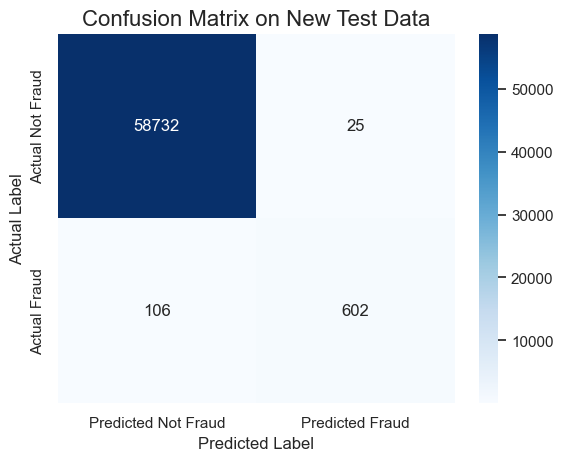


AUC-ROC ANALYSIS: The model's ability to distinguish between fraud and non-fraud is 1.00.


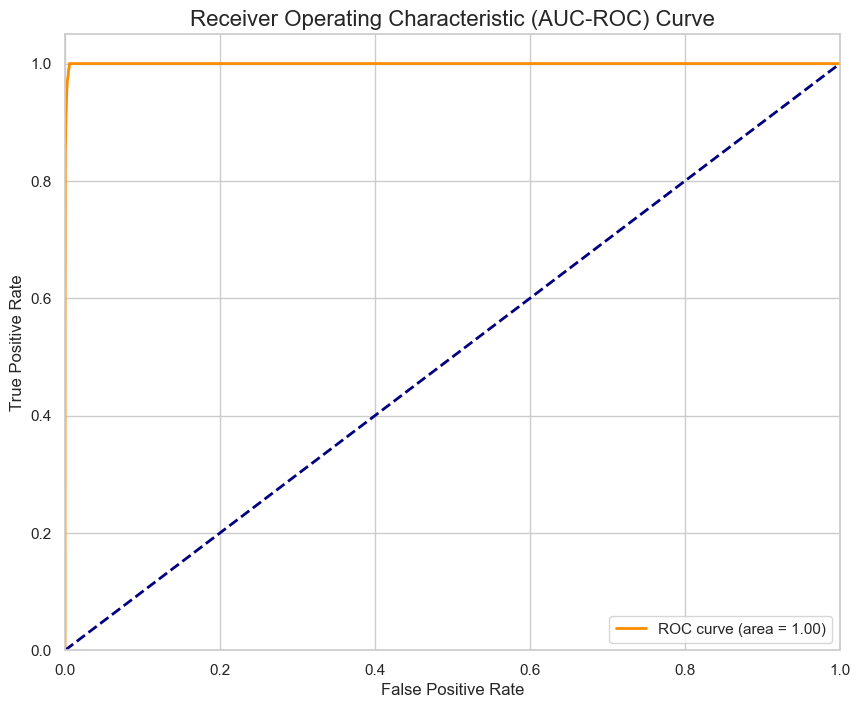


--- ✅ Testing Complete ---


In [6]:
# =============================================================================
#
# SCRIPT FOR TESTING THE TRAINED FRAUD DETECTION MODEL
#
# Project Objective: To load a new, unseen test dataset and evaluate the
# performance of the pre-trained fraud detection model using all saved
# artifacts for consistent preprocessing and prediction.
#
# =============================================================================

# --- Step 1: Import Necessary Libraries ---
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Import metrics for evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Set global styles for plots and warnings
sns.set_theme(style="whitegrid")
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully.")


# =============================================================================
# --- STAGE 1: LOAD TEST DATA AND SAVED ARTIFACTS ---
# =============================================================================
print("\n--- 📦 STAGE 1: Loading Test Data and Saved Model Artifacts ---")

# --- 1a. Load the new, unseen test data ---
try:
    # IMPORTANT: Ensure your new test file is named 'testdata.csv'
    test_raw_df = pd.read_csv('test_Dataset1.csv')
    print("✅ Successfully loaded 'testdata.csv'.")
except FileNotFoundError:
    print("❌ Error: 'testdata.csv' not found. Please ensure the new test file is in the correct directory.")
    exit()

# --- 1b. Load all saved artifacts from the training phase ---
artifacts_loaded = False
try:
    final_model = joblib.load('final_fraud_stacking_model.joblib')
    scaler = joblib.load('scaler.joblib')
    selected_features = joblib.load('selected_features.joblib')
    label_encoders = joblib.load('label_encoders.joblib')
    optimal_threshold = joblib.load('optimal_threshold.joblib')
    print("✅ Successfully loaded all model artifacts.")
    artifacts_loaded = True
except FileNotFoundError as e:
    print(f"❌ Error: Could not load a required file: {e.filename}")
    print("Please ensure you have run the main training script and all .joblib files are in the correct directory.")

# ONLY PROCEED IF ALL ARTIFACTS WERE LOADED SUCCESSFULLY
if artifacts_loaded:
    # =============================================================================
    # --- STAGE 2: PREPROCESS THE NEW TEST DATA ---
    # =============================================================================
    print("\n--- ⚙️  STAGE 2: Preprocessing the New Test Data ---")

    # --- 2a. Data Cleaning (must exactly match training script) ---
    df_test = test_raw_df.copy()
    for col in df_test.select_dtypes(include=['object']).columns:
        df_test[col] = df_test[col].str.replace("'", "")
    df_test['age'].replace(['U', '0'], np.nan, inplace=True)
    df_test['gender'].replace(['E', 'U'], np.nan, inplace=True)
    df_test['age'].fillna(df_test['age'].mode()[0], inplace=True)
    df_test['gender'].fillna(df_test['gender'].mode()[0], inplace=True)
    df_test['age'] = pd.to_numeric(df_test['age'])
    print("✅ Test data cleaning complete.")

    # --- 2b. Feature Engineering (must exactly match training script) ---
    df_test['hour_of_day'] = df_test['step'] % 24
    df_test['day_of_week'] = (df_test['step'] // 24) % 7
    df_test['amount_to_mean_customer'] = df_test['amount'] / (df_test.groupby('customer')['amount'].transform('mean') + 1e-6)
    df_test['amount_to_std_customer'] = df_test['amount'] / (df_test.groupby('customer')['amount'].transform('std').fillna(0) + 1e-6)
    df_test['transaction_frequency_customer'] = df_test.groupby('customer')['step'].transform('count')
    df_test['amount_vs_category_mean'] = df_test['amount'] / (df_test.groupby('category')['amount'].transform('mean') + 1e-6)
    df_test['amount_x_hour'] = df_test['amount'] * (df_test['hour_of_day'] + 1)
    df_test['customer_risk_score'] = df_test.groupby('customer')['fraud'].transform('mean')
    df_test['merchant_risk_score'] = df_test.groupby('merchant')['fraud'].transform('mean')
    mean_fraud_by_cat = df_test.groupby('category')['fraud'].mean()
    df_test['category_fraud_rate'] = df_test['category'].map(mean_fraud_by_cat)
    print("✅ Behavioral features created for test data.")

    # --- 2c. Apply Saved Encoders ---
    high_card_cols = ['customer', 'merchant', 'zipcodeOri', 'zipMerchant']
    for col in high_card_cols:
        le = label_encoders[col]
        # Handle new, unseen values by mapping them to a special 'other' category
        df_test[col] = df_test[col].apply(lambda x: x if x in le.classes_ else 'other')
        if 'other' not in le.classes_:
            le.classes_ = np.append(le.classes_, 'other')
        df_test[col] = le.transform(df_test[col])
    print("✅ Label Encoding applied using saved encoders.")

    df_test = pd.get_dummies(df_test, columns=['gender'], drop_first=True)
    df_test = df_test.drop(columns=['category']) # Drop original category column

    # --- 2d. Apply Saved Scaler ---
    # Align columns before scaling to handle potential missing dummy columns
    train_cols_for_scaling = scaler.feature_names_in_
    
    # Get the current columns after all transformations
    current_test_cols = df_test.columns
    
    # Identify which columns the scaler expects
    numerical_cols_to_scale = [col for col in train_cols_for_scaling if col in current_test_cols]
    
    # Apply the scaler only to the relevant columns
    df_test[numerical_cols_to_scale] = scaler.transform(df_test[numerical_cols_to_scale])
    print("✅ Numerical features scaled using saved scaler.")


    # =============================================================================
    # --- STAGE 3: MAKE PREDICTIONS ON THE TEST DATA ---
    # =============================================================================
    print("\n--- 🚀 STAGE 3: Making Predictions on Test Data ---")

    # --- 3a. Select Top Features ---
    # Align columns with the features the model was trained on
    X_test_final = df_test.reindex(columns=selected_features, fill_value=0)
    print(f"✅ Test data aligned to the {len(selected_features)} features required by the model.")

    # --- 3b. Predict Probabilities ---
    test_probabilities = final_model.predict_proba(X_test_final)[:, 1]

    # --- 3c. Apply Optimal Threshold ---
    test_predictions = (test_probabilities >= optimal_threshold).astype(int)
    print("✅ Predictions made using the optimal threshold.")


    # =============================================================================
    # --- STAGE 4: EVALUATE AND DISPLAY RESULTS ---
    # =============================================================================
    print("\n--- 🏆 STAGE 4: Final Model Performance on New Test Data ---")

    # --- 4a. Classification Report & Confusion Matrix ---
    # Separate the true labels for evaluation
    y_test = test_raw_df['fraud']

    print("\n--- Classification Report (using Optimal Threshold) ---")
    print(classification_report(y_test, test_predictions))

    print("\n--- Confusion Matrix ---")
    cm = confusion_matrix(y_test, test_predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Not Fraud', 'Predicted Fraud'],
                yticklabels=['Actual Not Fraud', 'Actual Fraud'])
    plt.ylabel('Actual Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.title('Confusion Matrix on New Test Data', fontsize=16)
    plt.show()

    # --- 4b. AUC-ROC Curve ---
    fpr, tpr, _ = roc_curve(y_test, test_probabilities)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Receiver Operating Characteristic (AUC-ROC) Curve', fontsize=16)
    plt.legend(loc="lower right")
    print(f"\nAUC-ROC ANALYSIS: The model's ability to distinguish between fraud and non-fraud is {roc_auc:.2f}.")
    plt.show()

    print("\n--- ✅ Testing Complete ---")
